`Proton radiography` by Ganesaratnam Ganushan and Hassani Brahim
======================================

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy import signal

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import plasmapy as pp
import astropy.constants as const
import astropy.units as u
from plasmapy.diagnostics import charged_particle_radiography as cpr
from plasmapy.plasma.grids import CartesianGrid


# `B_field` code in 1D

In [2]:
class profil_1D:
    def __init__(self, width_axis, amplitude, kind):
        """
        :param width_axis: tuple or list containing lower and higher boundaries of B_field along the axis
        :param amplitude: scalar number containing the norm of B_field
        :param kind: kind = string containing "heaviside" or "gaussian" or "hyperbolic"
        """
        
        assert(len(width_axis) == 2)
        assert(np.shape(amplitude) == ())
        assert(kind in ["heaviside", "gaussian", "hyperbolic"])
        
        self.radius = width_axis
        self.a = width_axis[0]
        self.b = width_axis[1]
        self.B0 = amplitude
        self.kind = kind
        
        if kind == "heaviside":
            self.func = lambda x: self.B0*np.heaviside(x-self.a,1)*(1-np.heaviside(x-self.b, 1))
        elif kind == "gaussian":
            x_bar = (self.b+self.a)/2                                                              # average for gaussian function
            sigma = (self.b-self.a)/2                                                              # standard deviation for gaussian function
            self.func = lambda x: self.B0*np.exp(-(x-x_bar)**2/((np.sqrt(2)*sigma)**2))
        elif kind == "hyperbolic":
            self.func = lambda x: (((np.tanh(x-self.a))*(np.tanh(-x+self.b))+1))*(np.exp(-(self.b-self.a)/2.25)+1)*(self.B0/2)
    
    def __repr__(self):
        return "profil_1D (... width : {0} ... B0 : {1} ... kind : {2} ...)".format(self.radius, self.B0, self.kind)

    def __call__(self, x):
        return self.func(x)

    def plot(self, N=200):
        fig = plt.subplot()
        x = np.linspace(-2.5*(self.b-self.a), 2.5*(self.b-self.a), N) + (self.b+self.a)/2
        plt.plot(x, self.__call__(x), label = str(self.kind)+str(': ')+'[B0 , lower bound , higher bound] = '+str('[')+str(self.B0)+str(' , ')+str(self.a)+str(' , ')+str(self.b)+str(']'))
        plt.xlabel("axis")
        plt.ylabel("B_field intensity ( T )")
        plt.title("B_field 1D profile")
        plt.legend(loc="upper right")

*B_field plot in 1D*
------------------------------------------------------------------------------

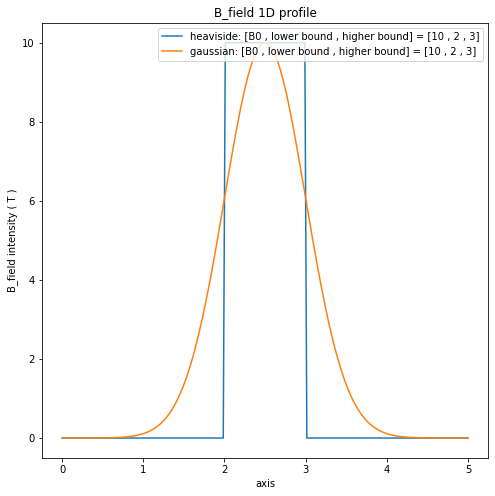

In [3]:
# input parameters: (lower boundary of B_field and upper boundary of B_field), norm of B_field, kind of function

x = profil_1D((2,3), 10, kind="heaviside")
y = profil_1D((2,3), 10, kind="gaussian")
#z = profil_1D((2,3), 10, kind="hyperbolic")

plt.figure(figsize=(8,8))
x.plot()
y.plot()
#z.plot()

# `B_field` code in 2D

In [4]:
class profil_2D:
    def __init__(self, center, width_xy, amplitude, kind):
        """
        :param center: tuple or list containing x coordinate and y coordinate of the B_field's center in 2D
        :param width_xy: tuple or list containing lower and higher boundaries of B_field in the (x,y) plane
        :param amplitude: scalar number containing the norm of B_field
        :param kind: kind = string containing "heaviside" or "gaussian" or "hyperbolic"
        """
        
        assert(len(center) == 2)
        assert(len(width_xy) == 2)
        assert(np.shape(amplitude) == ())
        assert(kind in ["heaviside", "gaussian", "hyperbolic"])

        self.radius = width_xy
        self.center = center
        self.kind = kind 
        self.a = width_xy[0]
        self.b = width_xy[1]
        self.B0 = amplitude

    
    def __repr__(self):
        return "profil_2D (... center : {0} ... width_xy : {1} ... B0 : {2} ... kind : {3} ...)".format(self.center, self.radius, self.B0, self.kind)
    
    def __call__(self,x,y):
        r = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
        return profil_1D(self.radius,self.B0,self.kind)(r)

    def plot(self, N=300):
        x_tab = np.linspace(-1.75*self.b,1.75*self.b,N)
        y_tab = np.linspace(-1.75*self.b,1.75*self.b,N)  
        X, Y = np.meshgrid(x_tab,y_tab)
        fig, ax = plt.subplots(figsize=(8,8))
        c = ax.pcolor(X+self.center[0],Y+self.center[1],self.__call__(X,Y),norm=plt.Normalize(vmin=0, vmax=self.B0),cmap="magma_r",label='[B0 , lower bound , higher bound] = '+str('[')+str(self.B0)+str(' , ')+str(self.a)+str(' , ')+str(self.b)+str(']'))
        cb = fig.colorbar(c,ax=ax)
        cb.ax.set_ylabel("B_field intensity ( T )")
        ax.legend(loc = "upper right")
        plt.title("B_field 2D profile by "+str(self.kind)+str(' function'))
        ax.axis("equal")
        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        fig.tight_layout()
        return fig, ax

*B_field plot in 2D*
------------------------------------------------------------------------------

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'B_field 2D profile by gaussian function'}, xlabel='x-axis', ylabel='y-axis'>)

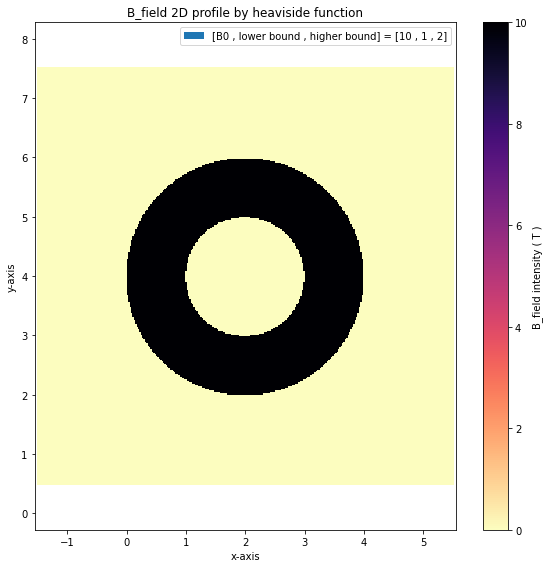

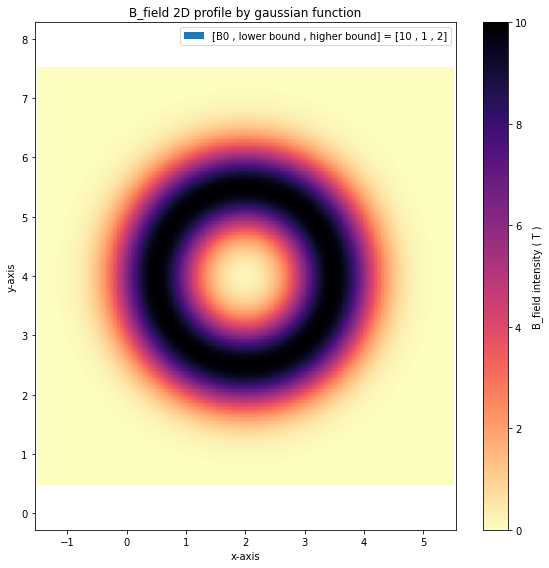

In [5]:
# input parameters: (center coordinates of B_field in 2D), (lower and upper boundaries of B_field in the plane), norm of B_field, kind of function

F=profil_2D((2,4),(1, 2), 10, kind="heaviside")
G=profil_2D((2,4),(1, 2), 10, kind="gaussian")
#H=profil_2D((2,4),(1, 2), 10, kind="hyperbolic")

F.plot()
G.plot()
#H.plot()

# `B_field` code in 3D

In [6]:
class profil_3D:
    def __init__(self, center, width_xy, width_z, amplitude, kind):
        """
        :param center: tuple or list containing x coordinate and y coordinate of the B_field's center in 2D
        :param width_xy: tuple or list containing lower and higher boundaries of B_field in the (x,y) plane
        :param width_z: tuple or list containing lower and higher boundaries of B_field along the z-axis
        :param amplitude: scalar number containing the norm of B_field
        :param kind: kind = string containing "heaviside" or "gaussian" or "hyperbolic"
        """
        
        assert(len(center) == 2)
        assert(len(width_xy) == 2)
        assert(len(width_z) == 2)
        assert(np.shape(amplitude) == ())
        assert(kind in ["heaviside", "gaussian", "hyperbolic"])
 
        self.radius = width_xy
        self.pos = width_z
        self.center = center
        self.kind = kind
        self.a = width_xy[0]
        self.b = width_xy[1]
        self.z0 = width_z[0]
        self.z1 = width_z[1]
        self.B0 = amplitude

    
    def __repr__(self):
        return "profil_3D (... center : {0} ... radius : {1} ... pos : {2} ... B0 : {3} ... kind : {4} ...)".format(self.center, self.radius, self.pos, self.B0, self.kind)
    
    def __call__(self,x,y,z):
        return profil_2D(self.center,self.radius,self.B0,self.kind)(x,y)*profil_1D(self.pos,self.B0,self.kind)(z)*(1/self.B0)
    

    
    def lineout(self, axis, fixed_parameters, N=200):
        """
        :param axis: string containing "x" or "y" or "z"
        :param fixed_parameters: tuple or list containing 2 other fixed coordinates in circular permutation
        """
        
        assert(axis in ['x', 'y', 'z'])
        assert(len(fixed_parameters) == 2)
        import string
        
        tab_xy = np.linspace(-2*self.b,2*self.b,N)
        tab_z = np.linspace(-2*self.z1,2*self.z1,N)
        Y,Z,X = np.meshgrid(tab_xy,tab_z,tab_xy)
        B = profil_3D( self.center, self.radius, self.pos, self.B0,self.kind)(X,Y,Z)
        a = list(string.ascii_lowercase)[23:]
        axis_indice = a.index(axis)
        param_1 = a[(axis_indice +1)%3]
        param_2 = a[(axis_indice +2)%3]
        param_1_value = fixed_parameters[0]
        param_2_value = fixed_parameters[1]
        
        if axis == 'x':
            tab = tab_xy
            param_1_indice = np.abs(tab_xy + self.center[1]-param_1_value).argmin()
            param_2_indice = np.abs(tab_z-param_2_value).argmin()
            cut = B[param_2_indice,param_1_indice,:]
        elif axis == 'y':
            tab = tab_xy
            param_1_indice = np.abs(tab_z-param_1_value).argmin()
            param_2_indice = np.abs(tab_xy + self.center[0]-param_2_value).argmin()
            cut = B[param_1_indice,:,param_2_indice]
        elif axis == 'z':
            tab = tab_z 
            param_1_indice = np.abs(tab_xy + self.center[0]-param_1_value).argmin()
            param_2_indice = np.abs(tab_xy + self.center[1]-param_2_value).argmin()
            cut = B[:,param_2_indice,param_1_indice]
        
        #plt.figure(figsize=(8,8))
        plt.plot(tab,cut,label = str(self.kind)+str(': ')+'[B0, min_xy, max_xy, min_z, max_z] = '+str('[')+str(self.B0)+str(' , ')+str(self.a)+str(' , ')+str(self.b)+str(' , ')+str(self.z0)+str(' , ')+str(self.z1)+str(']'))
        plt.xlabel(str(axis)+str('-axis with')+str(' [')+str(param_1)+str(' , ')+str(param_2)+str('] =')+str(' [')+str(param_1_value)+str(' , ')+str(param_2_value)+str(']'))
        plt.ylabel("B_field intensity ( T )")
        plt.title("B_field lineout")
        plt.legend(loc = "upper right")
            

    
    
    
    def slice(self, plane, fixed_parameter, N=200): # slab ?
        """
        :param plane: string containing "yx" or "xz" or "zy"
        :param fixed_parameter: scalar number containing the fixed coordinate
        """
        
        assert(plane in ['yx', 'xz', 'zy'])
        assert(np.shape(fixed_parameter) == ())
        import string
        
        tab_xy = np.linspace(-1.75*self.b,1.75*self.b,N)
        tab_z = np.linspace(-1.75*self.z1 + (self.z1+self.z0)/2,1.75*self.z1 + (self.z1+self.z0)/2,N)
        Y,Z,X=np.meshgrid(tab_xy,tab_z,tab_xy)
        B = profil_3D( self.center, self.radius, self.pos, self.B0,self.kind)(X,Y,Z)
        a = list(string.ascii_lowercase)[23:]
        
        if plane == 'yx':
            X,Y = np.meshgrid(tab_xy,tab_xy)
            tab_1 = Y + self.center[1]
            tab_2 = X + self.center[0]
            param_indice = np.abs(tab_z-fixed_parameter).argmin()
            cut = B[param_indice,:,:]
            fixed_indice = 2
        elif plane == 'xz':
            X,Z = np.meshgrid(tab_xy,tab_z)
            tab_1 = X + self.center[0]
            tab_2 = Z 
            param_indice = np.abs(tab_xy-fixed_parameter).argmin()
            cut = B[:,param_indice,:]
            fixed_indice = 1
        elif plane == 'zy':
            Y,Z = np.meshgrid(tab_xy,tab_z)
            tab_1 = Z 
            tab_2 = Y + self.center[1]
            param_indice = np.abs(tab_xy-fixed_parameter).argmin()
            cut = B[:,:,param_indice]
            fixed_indice = 0
            
        fig, ax = plt.subplots(figsize=(8,8))
        c = ax.pcolor(tab_1,tab_2,cut,norm=plt.Normalize(vmin=0, vmax=self.B0),cmap="magma_r",label=str('[')+str(a[fixed_indice])+str(', ')+'B0, min_xy, max_xy, min_z, max_z] = '+str('[')+str(fixed_parameter)+str(' , ')+str(self.B0)+str(' , ')+str(self.a)+str(' , ')+str(self.b)+str(' , ')+str(self.z0)+str(' , ')+str(self.z1)+str(']'))
        cb = fig.colorbar(c,ax=ax)
        cb.ax.set_ylabel("B_field intensity ( T )")
        ax.legend(loc="upper right")
        plt.title("B_field slice by "+str(self.kind)+str(' function'))
        #ax.axis("equal")
        ax.set_xlabel(str(a[(fixed_indice-1)%3])+"-axis")
        ax.set_ylabel(str(a[(fixed_indice-2)%3])+"-axis")
        fig.tight_layout()
        
    
        

    def plot_3D(self, N=300):
        x_tab = np.linspace(-2*self.b,2*self.b,N)
        y_tab = np.linspace(-2*self.b,2*self.b,N)
        z_tab = np.linspace(self.z0,self.z1,N)
        X,Y = np.meshgrid(x_tab,y_tab)
        Z = z_tab
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(X+self.center[0],Y+self.center[1],self.__call__(X,Y,Z),norm=plt.Normalize(vmin=0, vmax=self.B0),cmap=cm.plasma,linewidth=0, antialiased=False)
        cb = fig.colorbar(surf,orientation="vertical",pad=0.2)
        cb.ax.set_ylabel("B_field intensity scale ( T )")
        plt.title("B_field 3D profile by "+str(self.kind)+str(' function'))
        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("B_field intensity")
        fig.tight_layout()

*B_field plot along an axis*
------------------------------------------------------------------------------

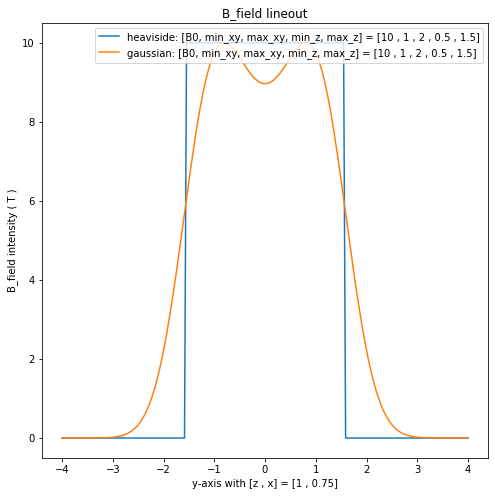

In [7]:
# input lineout parameters: "x" or "y" or "z", tuple or list containing 2 other fixed coordinates in circular permutation

center = (2,1)
radius_xy = (1,2)
radius_z = (0.5,1.5)
B0 = 10
x = 0.75
y = 0
z = 1

F=profil_3D(center, radius_xy, radius_z, B0, kind="heaviside")
G=profil_3D( center, radius_xy, radius_z, B0,kind="gaussian")
#H=profil_3D( center, radius_xy, radius_z, B0,kind="hyperbolic")

plt.figure(figsize=(8,8))
F.lineout(axis='y', fixed_parameters=[z,x])
G.lineout(axis='y', fixed_parameters=[z,x])
#H.lineout(axis='y', fixed_parameters=[z,x])

*B_field plot in a plane*
------------------------------------------------------------------------------

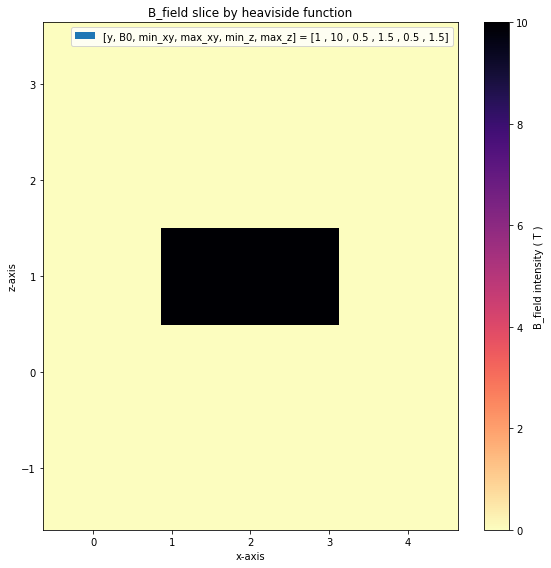

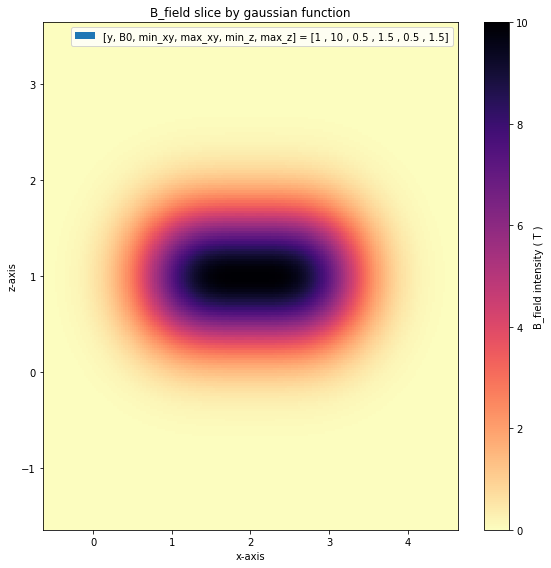

In [29]:
# input slice parameters: "yx" or "xz" or "zy", scalar number containing the fixed coordinate

center = (2,1)
radius_xy = (0.5,1.5)
radius_z = (0.5,1.5)
B0 = 10
x = 0
y = 1
z = 0

F=profil_3D( center, radius_xy, radius_z, B0,kind="heaviside")
G=profil_3D( center, radius_xy, radius_z, B0,kind="gaussian")
#H=profil_3D( center, radius_xy, radius_z, B0,kind="hyperbolic")

F.slice(plane='xz', fixed_parameter=y)
G.slice(plane='xz', fixed_parameter=y)
#H.slice(plane='zy', fixed_parameter=x)

*B_field plot in 3D ( xy-plane with B_field intensity in 3rd axis )*
------------------------------------------------------------------------------

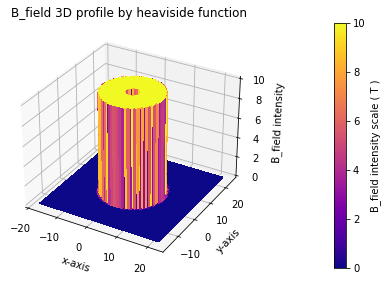

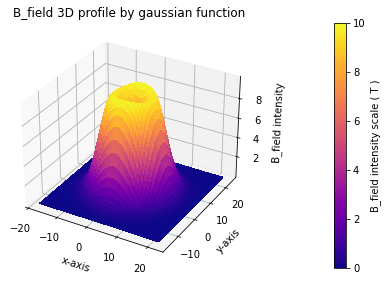

In [25]:
# input parameters: (center coordinates of B_field in 2D), (lower and upper boundaries of B_field in the plane), (lower and upper boundaries of B_field along the 3rd axis), norm of B_field, kind of function

F=profil_3D( (2,4), (2,10), (0.5,1.5), 10,kind="heaviside")
G=profil_3D( (2,4), (2,10), (0.5,1.5), 10,kind="gaussian")
#H=profil_3D( (2,4), (2,10), (0.5,1.5), 10,kind="hyperbolic")

F.plot_3D()
G.plot_3D()
#H.plot_3D()

le plot __de la figure__ du *dessous* est ici $pour_une_altitude_z_variable$

# `Proton radiography test` with fields (E,B) = (0,0)

Source: [ 0.   -0.01  0.  ] m
Detector: [0.  0.1 0. ] m
Magnification: 11.0
Creating Particles
Particles on grid:   0%|          2.4e+01/1.0e+04 particles
Run completed
Fraction of particles tracked: 100.0%
Fraction of tracked particles that entered the grid: 100.0%
Fraction of tracked particles deflected away from the detector plane: 0.0%
Maximum deflection α = 0.00 deg


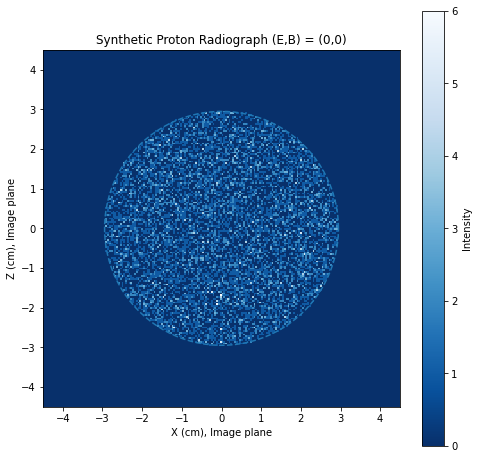

In [10]:
# Create a Cartesian grid
N = 100                                                             # number of points in the grid
L = 3* u.mm                                                         # size of the grid
angle_max = (15*np.pi)/180                                          # maximum angle of deflection
grid = CartesianGrid(-L, L, num=N)                                  # creation of the cartesian grid


# Calculate E and B
xtab = np.linspace(-3,3,N)
ytab = np.linspace(-3,3,N)
ztab = np.linspace(-3,3,N)
y,z,x = np.meshgrid(ytab,ztab,xtab)                                 # creation of points in cartesian benchmark (X-axis,Y-axis,Z-axis)

Ex = np.zeros((N,N,N))*u.V/u.m
Ey = np.zeros((N,N,N))*u.V/u.m
Ez = np.zeros((N,N,N))*u.V/u.m
Bx = np.zeros((N,N,N))*u.T
By = np.zeros((N,N,N))*u.T
Bz = np.zeros((N,N,N))*u.T
grid.add_quantities(E_x=Ex, E_y=Ey, E_z=Ez, B_x=Bx, B_y=By, B_z=Bz) # Add those quantities to the grid and plot the B-field



def plot_radiograph(hax, vax, intensity, xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot = ax.pcolormesh(hax.to(u.cm).value,vax.to(u.cm).value,intensity.T,cmap="Blues_r",shading="auto",)
    cb = fig.colorbar(plot)
    R = np.tan(angle_max)*11
    theta = np.linspace(0,2*np.pi,100)
    x = np.cos(theta)*R
    y = np.sin(theta)*R
    plt.plot(x,y,"--")
    cb.ax.set_ylabel("Intensity")
    ax.set_aspect("equal")
    ax.set_xlabel("X (cm), Image plane")
    ax.set_ylabel("Z (cm), Image plane")
    ax.set_title("Synthetic Proton Radiograph (E,B) = (0,0)")
    if xlim is not None : #if xlim != None
        ax.set_xlim([-1.5, 1.5])



# Start simulation with parameters
source = (0 * u.mm, -10 * u.mm, 0 * u.mm)                           # coordonates of the source in cartesian benchmark (X-axis,Y-axis,Z-axis)
detector = (0 * u.mm, 100 * u.mm, 0 * u.mm)                         # coordonates of the detector in cartesian benchmark ((X-axis,Y-axis,Z-axis)
sim = cpr.Tracker(grid, source, detector, verbose=True)
sim.create_particles(10**4, 3 * u.MeV, max_theta=angle_max * u.rad, particle="p") # parameters for protons beam
sim.run()
size = np.array([[-1, 1], [-1, 1]]) * 4.5 * u.cm                    # size of the radiograph
bins = [200, 200]                                                   # number of pixels on the radiograph
hax, vax, intensity = cpr.synthetic_radiograph(sim, size=size, bins=bins)
plot_radiograph(hax, vax, intensity)

max_deflection = sim.max_deflection
a = 1 * u.mm
l = np.linalg.norm(sim.source * u.m).to(u.mm)
mu = l * max_deflection.value / a
print(f"Maximum deflection α = {np.rad2deg(max_deflection):.2f}")
#plt.savefig("radiographe_hyperbolic_1.jpg",dpi = 300)

# `Proton radiography` with fields (E,B) = (0,variable)

## Highland_scattering

In [11]:
class gaussian_Highland:
    def __init__(self, L, L_r, v, p, E):
        self.L = L         # radiation length of the material
        self.L_r = L_r     # thickness of the target
        self.v = v         # incident proton velocity
        self.p = p         # momentum of the incident proton
        self.E = E         # proton energy
    
    def __repr__(self):
        return "scattering_angle_Highland(L : {0} ... L_r : {1} ... v : {2} ... p : {3} ... E : {4})".format(self.L, self.L_r, self.v, self.p, self.E)

    def __call__(self, x, N=100):
        #theta0 = (self.E/(self.v*self.p))*np.sqrt(self.L/self.L_r)*(1+0.038*np.log(self.L/self.L_r))
        theta0 = (0.1*np.pi)/180
        print('-----------------')
        print("Scattering angle = "+str((theta0*180)/np.pi)+str(' deg'))
        print('-----------------')
        func = lambda x: np.exp(-x**2/((np.sqrt(2)*theta0)**2))/(theta0*np.sqrt(2*np.pi))
        return func(x)
        
    def plot_test(self, x, radius_axis, B_field, kind):
        func = profil_1D( radius_axis, B_field, kind)(x)
        a = np.linspace(-10, 10,2*np.shape(x)[0]-1)
        A = scipy.signal.convolve(self.__call__(x, N=len(x)),func)
        fig,ax = plt.subplots(3,1)
        ax[0].plot(x,func,"r",label='initial function')
        ax[1].plot(x,self.__call__(x, N=len(x)),"black",label='Highland_gaussian')
        ax[2].plot(a,A,"violet",label='function after convolution')
        ax[0].legend(loc="upper right")
        ax[1].legend(loc="upper right")
        ax[2].legend(loc="upper right")
        fig.tight_layout()

-----------------
Scattering angle = 0.1 deg
-----------------
-----------------
Scattering angle = 0.1 deg
-----------------


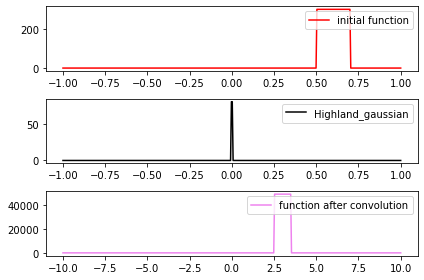

In [12]:
L = 64                                         # radiation length of the material
L_r = 15*10**-6                                # thickness of the target
v = 81*10**3                                   # incident proton velocity
p = 1.355*10**-22                              # momentum of the incident proton
E = 10*10**6*1.6*10**-19                       # proton energy                     

x = np.linspace(-1, 1, 400)
c = gaussian_Highland( L, L_r, v, p, E)
c.plot_test(x,(0.5,0.7), 300, kind='heaviside')

## Setup of the parameters of the grid

In [13]:
N = 100                            # number of points in the grid        TO BE INVREASED
L = 1* u.mm                        # size of the grid            TO BE INCVREASED ?
angle_max = (6*np.pi)/180          # maximum angle of deflection

## Creation of the grid 

In [14]:
grid = CartesianGrid(-L, L, num=N) # creation of the cartesian grid

## Setup of the parameters of B_field

In [15]:
xtab = np.linspace(-3,3,N)
ytab = np.linspace(-3,3,N)
ztab = np.linspace(0,3,N) 
z,y,x = np.meshgrid(ztab,ytab,xtab)                                           # creation of points in cartesian benchmark with data in mm 

Bx = profil_3D((0,0), (0.5,0.75), (0.5,1), 300, kind="gaussian")(x,y,z)*u.T   # creation of the B_field along x-axis
#By = np.zeros((N,N,N))*u.T                                                    # creation of the B_field along y-axis
By = profil_3D((0,0), (0.5,0.75), (0.5,1), 300, kind="gaussian")(x,y,z)*u.T
Bz = profil_3D((0,0), (0.5,0.75), (0.5,1), 300, kind="gaussian")(x,y,z)*u.T   # creation of the B_field along z-axis

## Creation of B_field 

In [16]:
grid.add_quantities(B_x=Bx, B_y=By, B_z=Bz) # Add those quantities to the grid and plot the B-field

## Setup of the parameters of source, detector and protons beam

In [17]:
D=100 * u.mm                                                                        # distance source-detector
source = (0 * u.mm, D-110 * u.mm, 0 * u.mm)                                         # coordonates of the source in cartesian benchmark (Y-axis,Z-axis,X-axis)
detector = (0 * u.mm, D-10 * u.mm, 0 * u.mm)                                        # coordonates of the detector in cartesian benchmark (Y-axis,Z-axis,X-axis)
sim = cpr.Tracker(grid, source, detector, verbose=True)
sim.create_particles(10**4, 3 * u.MeV, max_theta=angle_max * u.rad, particle="p")   # parameters for protons beam

Source: [ 0.   -0.01  0.  ] m
Detector: [0.   0.09 0.  ] m
Magnification: 10.0
Creating Particles


/home/hassani/.local/lib/python3.9/site-packages/plasmapy/plasma/grids.py:181: RuntimeWarning: E_x is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
/home/hassani/.local/lib/python3.9/site-packages/plasmapy/plasma/grids.py:181: RuntimeWarning: E_y is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
/home/hassani/.local/lib/python3.9/site-packages/plasmapy/plasma/grids.py:181: RuntimeWarning: E_z is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
/home/hassani/.local/lib/python3.9/site-packages/plasmapy/diagnostics/charged_particle_radiography.py:234: RuntimeWarning: Fields should go to zero at edges of grid to avoid non-physical effects, but a value of 3.32E+00 T was found on the edge of the B_x array. Consider applying a envelope function to force the fields at the edge to go to zero.
  warnings.warn(
/home/hassani/.local/lib/python3.9/site-packa

## Simulation of proton radiography

In [18]:
def plot_radiograph(hax, vax, intensity):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot = ax.pcolormesh(hax.to(u.cm).value,vax.to(u.cm).value,intensity.T,cmap="Blues_r",shading="auto",)
    cb = fig.colorbar(plot)
    R = np.tan(angle_max)*D
    theta = np.linspace(0,2*np.pi,100)
    x = np.cos(theta)*R
    y = np.sin(theta)*R
    plt.plot(x,y,"--",color='black')
    cb.ax.set_ylabel("Intensity")
    ax.set_aspect("equal")
    ax.set_xlabel("X (cm), Image plane")
    ax.set_ylabel("Y (cm), Image plane")
    ax.set_xlim(-size,size)
    ax.set_ylim(-size,size)
    return fig, ax

Particles on grid:   0%|          1.1e+01/1.0e+04 particles
Run completed
Fraction of particles tracked: 100.0%
Fraction of tracked particles that entered the grid: 100.0%
Fraction of tracked particles deflected away from the detector plane: 0.0%
-----------------
Scattering angle = 0.1 deg
-----------------
Maximum deflection α = 41.70 deg


Text(0.5, 1.0, "Synthetic Proton Radiograph without Highland's blurring")

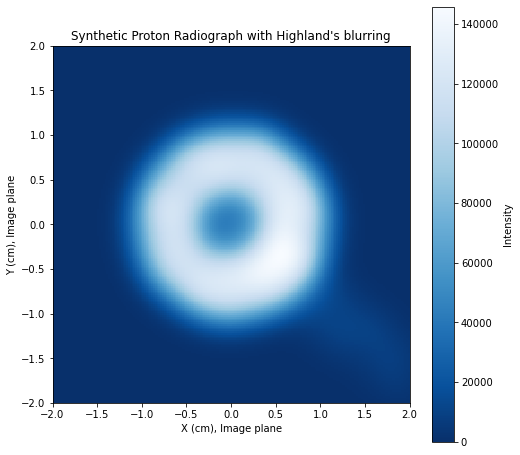

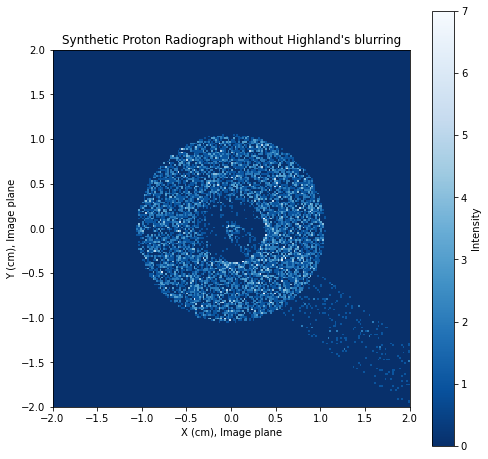

In [19]:
bins = 200                                     # number of pixels
size = 2                                       # size of the radiograph
L = 64                                         # radiation length of the material
L_r = 15*10**-6                                # thickness of the target
v = 81*10**3                                   # incident proton velocity
p = 1.355*10**-22                              # momentum of the incident proton
E = 10*10**6*1.6*10**-19                       # proton energy

sim.run()
s = np.array([[-1, 1], [-1, 1]]) * size * u.cm 
b = [bins, bins] 
h, v, intensity = cpr.synthetic_radiograph(sim, size=s, bins=b) 
X,Y = np.meshgrid(h/u.m,v/u.m)

H = gaussian_Highland( L, L_r, v, p, E)            
r = np.sqrt(np.multiply(X,X)+np.multiply(Y,Y))
I = scipy.signal.convolve(H(r),intensity)          # creation of Highland's blurring
tab = np.linspace(-2*size,2*size,2*bins-1)*u.cm    # creation of new axis corresponding to Highland's blurring

max_deflection = sim.max_deflection
a = 1 * u.mm
l = np.linalg.norm(sim.source * u.m).to(u.mm)
mu = l * max_deflection.value / a
print(f"Maximum deflection α = {np.rad2deg(max_deflection):.2f}") 

fig1, ax1 = plot_radiograph(tab, tab, I)                      # radiograph with Highland's blurring
fig2, ax2 = plot_radiograph(h, v, intensity)                  # radiograph without Highland's blurring
ax1.set_title("Synthetic Proton Radiograph with Highland's blurring")
ax2.set_title("Synthetic Proton Radiograph without Highland's blurring")

#plt.savefig("radiographe_heaviside_2.jpg",dpi = 300)

In [62]:
        #l1 = vect[0]-self.center[0]
        #l2 = vect[1]-self.center[1] 
        #l = np.vstack((l1,l2))
        #r = np.linalg.norm(l,axis=0)
        #print(profil_1D(self.radius,self.B0,self.kind)(r))
        #return profil_1D(self.radius,self.B0,self.kind)(r)
        #r = np.sqrt(np.multiply(x-self.center[0],x-self.center[0])+np.multiply(y-self.center[1],y-self.center[1]))

In [33]:
type(1.0)

float